# PointNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Voici une implémentation de l'approche PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation (https://arxiv.org/abs/1612.00593) réalisée en PyTorch.

![PointNet](http://stanford.edu/~rqi/pointnet/images/teaser.jpg)

L'architecture du modèle complet est illustrée ci-dessous.
![Réseaux](http://stanford.edu/~rqi/pointnet/images/pointnet.jpg)

##  PointNet : Partie Segmentation
Ici, nous allons nous focaliser sur la partie segmentation du réseau, qui correspond à la section attribuant une étiquette d'appartenance à chaque point du nuage de points d'un objet 3D donné en entrée.

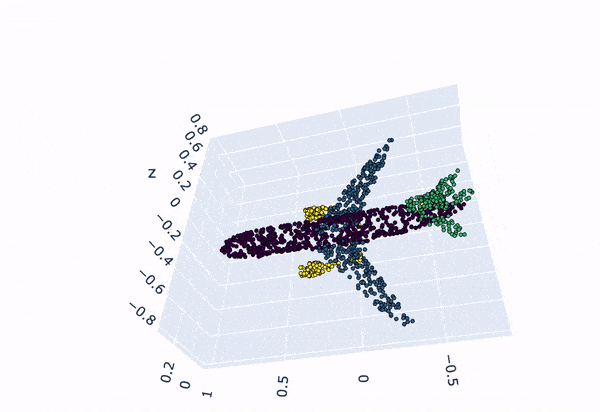

In [ ]:
!pip install path.py;
from path import Path
import sys
import plotly.graph_objects as go
import numpy as np
import scipy.spatial.distance
import math
import random

!pip install torchinfo

## Chargement des données

Le jeu de données comprend 10 nuages de points représentant différents avions, où chaque point possède ses coordonnées dans l’espace 3D ainsi qu’un label indiquant la partie de l’avion à laquelle il appartient : il y a 4 labels différents. Comme chaque nuage contient un nombre de points différent et que les fonctions de la bibliothèque PyTorch nécessitent des nuages de taille identique pour former un tenseur PyTorch, nous échantillonnons uniformément 2000 points dans chaque nuage de points.

In [ ]:
! wget https://github.com/PelissierCombescure/TP_PointNet-24-25/archive/refs/heads/main.zip -O TP_PointNet-24-25.zip
! unzip -q TP_PointNet-24-25.zip;

In [ ]:
import sys
import random
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.dataset import random_split


sys.path.append('/content/TP_PointNet-24-25-main')
import utils


In [ ]:
def read_pts(file):
    verts = np.genfromtxt(file)
    return verts

def read_seg(file):
    verts = np.genfromtxt(file, dtype= (int))
    return verts

def sample_2000(pts, pts_cat):
    res1 = np.concatenate((pts,np.reshape(pts_cat, (pts_cat.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=2000))
    nuages = res[:, 0:3]
    categories = res[:, 3]
    categories-=np.ones(categories.shape)
    return nuages, categories

## Model classification + segmentation


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      # Transformation Network: convolution layers to extract features from the input
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)

      # Fully connected layers to map features to a transformation matrix of size k x k
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      # Batch normalization layers for stabilizing training
      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # Input shape (batch_size, n_points, k)
      bs = input.size(0)

      # Convolution layers with ReLU and batch normalization
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))

      # Max pooling to get the global feature vector
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)

      # Fully connected layers to output transformation matrix
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()

      # Output transformation matrix with residual addition of identity
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        # Input and feature transformation networks
        self.input_transform = ...
        self.feature_transform = ...

        # Convolution layers for feature extraction
        ...

        # Batch normalization layers
        ...

   def forward(self, input):
        n_pts = input.size()[2]; outs = []
        # Apply input transformation to align points
        matrix3x3 = self.input_transform(input)

        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        # Feature extraction with first convolution layer
        xb = F.relu(self.bn1(self.conv1(xb)))

        # Apply feature transformation for rotation invariance
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)
        outs.append(xb)

        # Further feature extraction
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))

        # Global feature vector via max pooling across points
        global_feature = nn.MaxPool1d(xb.size(-1))(xb)

        # Flatten and repeat for each point
        xb = nn.Flatten(1)(global_feature).repeat(n_pts,1,1).transpose(0,2).transpose(0,1)#.repeat(1, 1, n_pts)
        outs.append(xb)

        return outs, matrix3x3, matrix64x64


class PointNetSeg(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        # Feature transformation network
        ...

        # Segmentation
        # Fully connected layers for segmentation
        ...

        # Batch normalization layers
        ...

        # LogSoftmax for output probability distribution across classes
        self.logsoftmax = nn.LogSoftmax(dim=1)


    def forward(self, input):
        # Pass input through feature transformation network
        inputs, matrix3x3, matrix64x64 = self.transform(input)
        # Concatenate feature outputs
        stack = torch.cat(inputs,1)

        # Fully connected layers with ReLU and batch normalization
        xb = F.relu(self.bn1(self.fc1(stack)))
        xb = F.relu(self.bn2(self.fc2(xb)))
        xb = F.relu(self.bn3(self.fc3(xb)))

        # Final output layer with LogSoftmax for segmentation
        output = F.relu(self.bn4(self.fc4(xb)))

        return self.logsoftmax(output), matrix3x3, matrix64x64



In [ ]:
from torchinfo import summary

# Create an instance of your model
model = PointNetSeg()  # Adjust classes if needed
summary(model, input_size=(10,3,2000))

Voici l'architecture à obtenir :

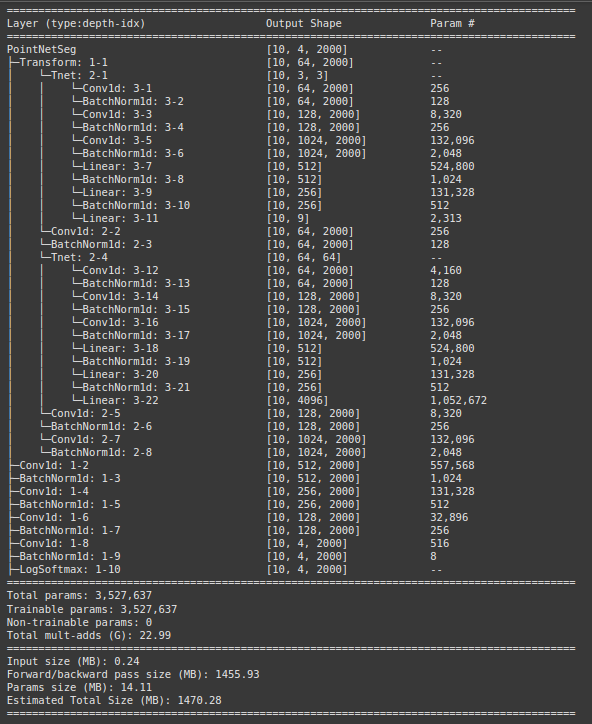

## Dataset

In [ ]:
class Data(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, valid=False, transform=None):
        self.files = []
        self.valid=valid

        newdir = '/content/TP_PointNet-24-25-main/expert_verified/points_label/'

        for file in os.listdir(newdir):
            o = {}
            o['category'] = newdir + file
            o['ptcloud_path'] = '/content/TP_PointNet-24-25-main/points/'+ file.replace('.seg', '.pts')
            self.files.append(o)


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        ptcloud_path = dset.files[idx]['ptcloud_path']
        category = dset.files[idx]['category']
        with open(ptcloud_path, 'r') as f:
            vertices = read_pts(f)
        with open(category, 'r') as f:
            category1 = read_seg(f)

        # On ne garde que 2000 pts
        vertices_sampled, category_sampled = sample_2000(vertices, category1)

        return {'nuage': np.array(vertices_sampled, dtype="float32"), 'category': category_sampled.astype(int)}


In [ ]:
# Création du dataset avec les 10 nuages de 2000pts chacun
dset = Data(transform=None)
data_loader = DataLoader(dataset=dset, batch_size=10)

print('######### Dataset class created #########')
print('Nombre de nuages de points :', len(dset))
print("Taille d'un nuage de points : ", dset[0]['nuage'].shape)


## Entrainement et Test



Téléchargez les poids ici : https://cloud.irit.fr/s/i5Y6n9v82g8dn3T

Puis importez fleche.png le fichier à partir du gestionnaire de fichier de la barre latéral, à gauche Capture d’écran du 2024-11-15 09-43-15.png



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
pointnet = PointNetSeg()
pointnet.load_state_dict(torch.load("/content/save_PointNet_seg_v2.pth", map_location=torch.device('cpu')))
pointnet.eval()

In [ ]:
# Récupération des 10 nuages de pts
batch = next(iter(data_loader))
nuages = ... ; print("Nuages : ",nuages.shape)
# Labels des 2000 pts/avions
labels = ... ; print("Labels :",labels.shape)

## Test : Prédiction des labels des 2000 pts/avions
# Vecteur de probabilité
pred = pointnet(nuages.transpose(1,2)); print("Vecteur de probabilités : ",pred[0].shape)
# Prédiction
pred_np = ... ; print("Prédictions : ",pred_np.shape)

## Accuracies
acc = ...

print("Accuracies :", acc)

Voici les résultats à obtenir :

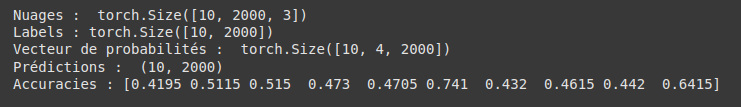

In [ ]:
# Visualisation de la meilleure segmentation
best_idx = np.argmax(acc); print(best_idx)
x,y,z=np.array(nuages[best_idx]).T
c = np.array(labels[best_idx]).T

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z,
                                   mode='markers',
                                   marker=dict(
        size=30,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.0
    ))])
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
fig.update_layout(scene=dict(aspectmode='cube'),  width=500, height=500)

fig.show()